In [5]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
import matplotlib.ticker as ticker
import ccxt
import datetime
import os
import re

# 기본 설정
binance = ccxt.binance(config={
    'options': {"defaultType" : "future"}
})

### 데이터 다운 및 업데이트 하기
def Save_and_Update_Data(coin, save_path):
    file_name = coin.replace("/USDT","_M") # 이름 수정
    
    if os.path.exists(os.path.join(save_path, f"{file_name}.xlsx"))==True: # 파일이 존재할 경우
        df = pd.read_excel(os.path.join(save_path,f"{file_name}.xlsx"),index_col=0)
        past = datetime.datetime.strptime(str(df.iloc[-1].name), f'%Y-%m-%d %H:%M:00')
        now = datetime.datetime.now().strftime(f'%Y-%m-%d %H:%M:00')
        now = datetime.datetime.strptime(now, f'%Y-%m-%d %H:%M:00')
        diff = str(now-past)
        h, m, s = list(map(int, diff.split(":")))
        total_time_diff = (h * 60) + m + s # 분으로 환산
        total_time_diff

        if total_time_diff > 0: # 1분 이상 차이 날 경우
            new_ohlcv = binance.fetch_ohlcv(
                f'{coin}', 
                timeframe='1m',
                params={"startTime":df.index[-1]},
                limit=total_time_diff
            )
            new_df = pd.DataFrame(new_ohlcv, columns=['datetime','open','high','low','close','volume'])
            Cal_DataFrame(new_df) # OHCLV 값 기반으로 계산
            new_df['datetime'] = pd.to_datetime(new_df['datetime'], unit='ms') + datetime.timedelta(hours=9)
            new_df.set_index('datetime',inplace=True)
            df = pd.concat([df,new_df])
#             print(f"[{coin}] Update {total_time_diff} minutes")
        else: # 1분 이하로 초단위로 차이 날 경우, 맨 마지막 행 업데이트
            new_ohlcv = binance.fetch_ohlcv(f'{coin}', timeframe='1m',limit=1)
            new_df = pd.DataFrame(new_ohlcv, columns=['datetime','open','high','low','close','volume'])
            Cal_DataFrame(new_df) # OHCLV 값 기반으로 계산
            new_df['datetime'] = pd.to_datetime(new_df['datetime'], unit='ms') + datetime.timedelta(hours=9)
            new_df.set_index('datetime',inplace=True)
            df = pd.concat([df[:-1],new_df])
#             print(f"[{coin}] Update Under 1 minutes")
    else: # 파일이 존재하지 않을 경우
        ### Data가 없을 때 1500개 1분봉 데이터 다운
#         print(f"[{coin}] New Data Saving . . .")
        ohlcv = binance.fetch_ohlcv(f'{coin}', timeframe='1m',limit=1500)
        df = pd.DataFrame(ohlcv, columns=['datetime','open','high','low','close','volume'])
        Cal_DataFrame(df) # OHCLV 값 기반으로 계산
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms') + datetime.timedelta(hours=9)
        df.set_index('datetime',inplace=True)
        time.sleep(0.5)

    df = df.loc[~df.index.duplicated(keep='last')] #최신행만 남겨두고 중복된 행 제거
    df.to_excel(f'{os.path.join(save_path, file_name)}.xlsx') # 엑셀 데이터로 저장
    
    return df
    
def Cal_DataFrame(DataFrame): #[time, open, high, low, close, volume]
    df = DataFrame
    
    # 가중치를 둔 거래대금
    df['Cal_Value'] = (df['open']*0.20+df['high']*0.15+df['low']*0.15+df['close']*0.50)*df['volume']
     

    return df


def Drawing_Graph(Data_Frame):
    plt.clf()
    df = Data_Frame[-60:].copy()
    # 그래프 구역 나누기
    top_axes = fig.add_subplot(111)
    plt.xticks(rotation=45)
    plt.setp(top_axes.get_xticklabels(), visible=False) # top_axes의 라벨 제거
    #----------------------------------------------------------------------------------#
    # 인덱스 설정
    idx = df.index[:].astype('str')
    # 이동평균선 그리기
    top_axes.plot(idx, df['close'], linewidth=0.7)
    #----------------------------------------------------------------------------------#
    # 캔들차트 그리기
    candlestick2_ohlc(top_axes, df['open'], df['high'], 
                      df['low'], df['close'],
                      width=0.5, colorup='r', colordown='b')
    #----------------------------------------------------------------------------------#
    # 그래프 title 지정
    top_axes.set_title(f'BTC', fontsize=20)
    # X축 티커 숫자 20개로 제한
    top_axes.xaxis.set_major_locator(ticker.MaxNLocator(10))
    
    fig.canvas.draw()
    
    plt.pause(0.01)
    
    
plt.close()

<IPython.core.display.Javascript object>


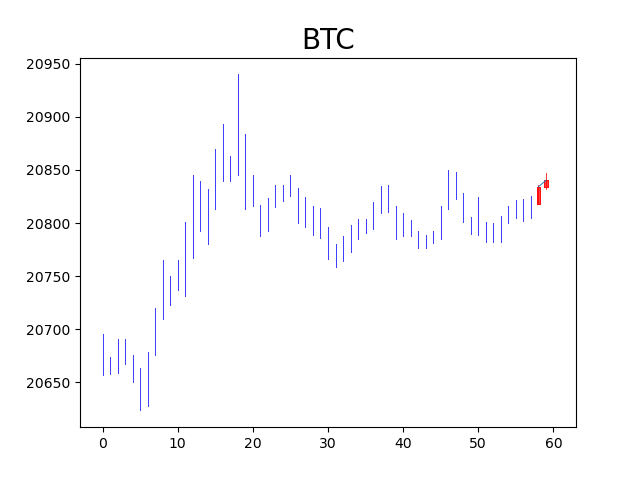

*-------------Start-------------*


KeyboardInterrupt: 

In [6]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

fig = plt.figure()
fig.show()

# 메인
coin ='BTC/USDT'
path = os.path.join(os.getcwd(),"Save Data") # 데이터 저장 위치


print("*-------------Start-------------*")
while True:
    df = Save_and_Update_Data(coin,path) # 데이터 저장 및 업데이트
    Drawing_Graph(df)
    time.sleep(0.01)

print("*--------------End--------------*")

In [ ]:
plt.close()

In [3]:
df

,open,high,low,close,volume,Cal_Value
datetime,,,,,,
2022-07-14 15:52:00,20041.7,20041.8,20018.7,20025.6,286.987,5.748411e+06
2022-07-14 15:53:00,20025.6,20028.3,20008.0,20012.2,310.325,6.211672e+06
2022-07-14 15:54:00,20012.3,20023.9,20004.0,20009.8,253.084,5.064602e+06
2022-07-14 15:55:00,20009.7,20016.8,20005.0,20012.9,188.390,3.769997e+06
2022-07-14 15:56:00,20012.9,20024.3,20011.1,20014.1,207.366,4.150418e+06
...,...,...,...,...,...,...
2022-07-15 16:48:00,20794.3,20819.6,20794.3,20809.1,423.018,8.801099e+06
2022-07-15 16:49:00,20809.1,20835.3,20809.1,20834.3,431.814,8.992799e+06
2022-07-15 16:50:00,20834.3,20835.4,20810.0,20810.0,398.726,8.300945e+06


In [12]:
idx = df.index[:].astype('str')

In [13]:
idx

Index(['2022-07-14 15:52:00', '2022-07-14 15:53:00', '2022-07-14 15:54:00',
       '2022-07-14 15:55:00', '2022-07-14 15:56:00', '2022-07-14 15:57:00',
       '2022-07-14 15:58:00', '2022-07-14 15:59:00', '2022-07-14 16:00:00',
       '2022-07-14 16:01:00',
       ...
       '2022-07-15 16:43:00', '2022-07-15 16:44:00', '2022-07-15 16:45:00',
       '2022-07-15 16:46:00', '2022-07-15 16:47:00', '2022-07-15 16:48:00',
       '2022-07-15 16:49:00', '2022-07-15 16:50:00', '2022-07-15 16:51:00',
       '2022-07-15 16:52:00'],
      dtype='object', name='datetime', length=1501)